## Gene similarity

In [1]:
#AUTOR : Adam Blazek

import numpy as np
import sys
import os
import subprocess
import seaborn as sns
import shutil # used for 'rm -r'
import json
import requests
import re
import matplotlib.pyplot as plt
from pandas import DataFrame
from tabulate import tabulate
from io import StringIO
from PIL import Image
from urllib import *
from pygraphviz import AGraph

filenames = []

# Flag determining whether the original assignment or the extended version featuring larger dataset and species
# should be used
#
# Re-run all the cells after altering this flag!
extended = True

if os.path.isdir('genes'):
    shutil.rmtree('genes')

if extended:
    cache = 'species_sim.npy'
    zipCache = 'species_zip.npy'
    specFile = 'species'
    imagesDir = 'images'
    shutil.copytree('genes_extended', 'genes')
else:
    os.mkdir('genes')
    cache = 'sim.npy'
    zipCache = 'zip.npy'
    specFile = 'letters'
    with open('all_seq.fasta','r') as all:
        data = all.read().split('>')[1:]
        for i in range(len(data)):
            with open(os.path.join('genes',str(i+1)+'.fasta'),'w') as fas:
                fas.write(">"+data[i])


#retrieves gene from a file in FASTA format
def readGene(filename):
    with open(filename, 'r') as f:
        data = f.read()
    return data[data.find('\n'):].replace('\n','')
    
    
#runs the GenCompress algorithm on the given gene and returns the size of the output
def compressGene(gene,condition):
    with open('tmp','w') as tmp:
        tmp.write(gene)
        if condition:
            with open('tmp_cond','w') as tmp_cond:
                tmp_cond.write(condition)
                os.system('./GenCompress tmp -c tmp_cond')
        else:
            os.system('./GenCompress tmp')
    size = os.stat('tmp.GEN').st_size
    os.remove('tmp')
    os.remove('tmp.GEN')
    os.remove('tmp.LOG')
    if condition:
        os.remove('tmp_cond')
    return size

def zipGene(gene):
    with open('tmp','w') as tmp:
        tmp.write(gene)
    os.system('gzip tmp')
    size = os.stat('tmp.gz').st_size
    os.remove('tmp.gz')
    return size

def zipGenes(gene,condition):
    if condition:
        return zipGene(condition+gene) - zipGene(condition)
    else:
        return zipGene(gene)

#returns similarity(distance) of the given genes
def geneSimilarity(uFile,vFile):
    u = readGene(uFile)
    v = readGene(vFile)
    cu = compressGene(u,None)
    cuv = compressGene(u+v,None)
    cu_v = compressGene(u,v)
    zu =  zipGenes(u,None)
    zuv = zipGenes(u+v,None)
    zu_v = zipGenes(u,v)
    return 1 - 1.0*(cu - cu_v)/cuv , 1 - 1.0*(zu - zu_v)/zuv 


## Similarity matrix

In [2]:
#AUTOR : Adam Blazek
def getNumber(filename):
    name = filename[filename.rfind(os.path.sep)+1:]
    return int(name[:name.find('.')])

for root, _, files in os.walk('genes'):      
    for filename in files:
        if(filename.endswith('.fasta')):
            filenames.append(os.path.join(root,filename))
            
size = len(filenames)
print('Found '+str(size)+' species')
simMatrix = np.zeros((size,size))
zipSimMatrix = np.zeros((size,size))

total = int(size*size-size)
done = 0
if os.path.isfile(cache):
    print ('Using cached similarity matrix')
    simMatrix = np.load(cache)
if os.path.isfile(zipCache):
    print ('Using cached zip matrix')
    zipSimMatrix = np.load(zipCache)
if not os.path.isfile(zipCache) or not os.path.isfile(cache):
    print('Calculating similarity')
    for i in range(0,size):
        for j in range(0,size):
            if i != j:
                uFile = filenames[i];
                vFile = filenames[j];
                uIndex = getNumber(uFile)-1
                vIndex = getNumber(vFile)-1
                simMatrix[uIndex,vIndex],zipSimMatrix[uIndex,vIndex] = geneSimilarity(uFile,vFile)
                done += 1
                sys.stdout.write("\r{}/{}".format(done,total))
                sys.stdout.flush()
    print('\nDone')

np.save(cache,simMatrix)
np.save(zipCache,zipSimMatrix)

Found 29 species
Using cached similarity matrix
Using cached zip matrix


## Nearest neighbours

In [3]:
#AUTOR : Adam Blazek
simTmp = simMatrix.copy()
zipTmp = zipSimMatrix.copy()
for i in range(0,size):
    simTmp[i,i]=1
    zipTmp[i,i]=1
nn = np.argmin(simTmp,0)
nnZip = np.argmin(zipTmp,0)

with open(specFile,'r') as speciesFile:
    species = speciesFile.read().split('\n')[:-1]
    
nns = [(species[i],species[nn[i]],species[nnZip[i]]) for i in range(0,size)]
print(tabulate(nns,headers=['Species','NN GenC','NN GZip'],tablefmt="fancy_grid"))

╒═══════════════════╤═══════════════════╤═══════════════════╕
│ Species           │ NN GenC           │ NN GZip           │
╞═══════════════════╪═══════════════════╪═══════════════════╡
│ baboon            │ common chimpanzee │ orangutan         │
├───────────────────┼───────────────────┼───────────────────┤
│ cat               │ harbor seal       │ dog               │
├───────────────────┼───────────────────┼───────────────────┤
│ common chimpanzee │ bonobo chimpanzee │ bonobo chimpanzee │
├───────────────────┼───────────────────┼───────────────────┤
│ bonobo chimpanzee │ common chimpanzee │ common chimpanzee │
├───────────────────┼───────────────────┼───────────────────┤
│ cow               │ sheep             │ sheep             │
├───────────────────┼───────────────────┼───────────────────┤
│ dog               │ gray seal         │ harbor seal       │
├───────────────────┼───────────────────┼───────────────────┤
│ donkey            │ horse             │ horse             │
├───────

## Heatmap

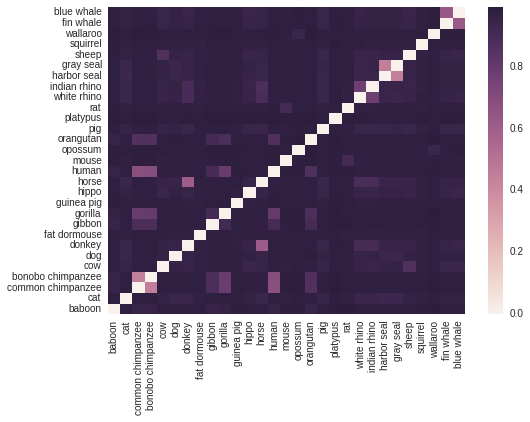

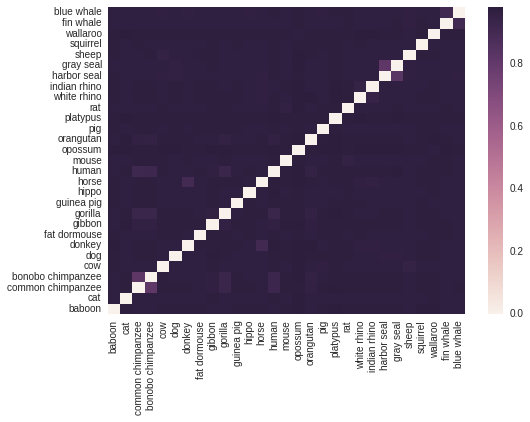

In [4]:
#AUTOR : Matej Kocian
#CO-AUTHOR : Adam Blazek

%matplotlib inline
sns.set()
simFrame = DataFrame(np.rot90(simMatrix),columns=species,index=reversed(species))
sns.heatmap(simFrame)
plt.figure()
zipFrame = DataFrame(np.rot90(zipSimMatrix),columns=species,index=reversed(species))
sns.heatmap(zipFrame)

## Phylogenetics tree

In [5]:
#AUTHOR Adam Blazek

def safeRemove(path):
    if os.path.isfile(path):
        os.remove(path)
        
def shortName(name):
    return name.replace(" ","")[:7]

def createTree(mat):
    safeRemove('outfile')
    safeRemove('outtree')
    with open('infile','w') as tmp:
        tmp.write("    "+str(size)+"\n")
        for i in range(size):
            name = shortName(species[i])
            tmp.write(name+(" "*(12-len(name))))
            for j in range(size):
                tmp.write("  {:.4f}".format(min(mat[i,j],mat[j,i])))
            tmp.write("\n")
    p = subprocess.Popen(['./neighbor','f'],stdout=subprocess.PIPE,stdin=subprocess.PIPE)
    p.stdin.write('Y\n')
    p.stdin.close()
    p.wait()

def readTree():
    with open('outfile','r') as res:
        data = res.read()
        data = data[data.find('allowed')+7:data.find('remember')]
        for i in range(size):
            data = data.replace(shortName(species[i]),species[i])
    return data
    
print('GZIP TREE:')
createTree(zipSimMatrix)
print(readTree())
    
print('GENCOMPRESS TREE:')
createTree(simMatrix)
print(readTree())

safeRemove('outfile')
safeRemove('infile')

GZIP TREE:



              +-----------------------common chimpanzee   
           +--1 
         +-5  +-----------------------bonobo chimpanzee   
         ! ! 
       +-6 +--------------------------human     
       ! ! 
     +-9 +---------------------------gorilla   
     ! ! 
  +-12 +----------------------------orangutan   
  !  !  
  !  +----------------------------gibbon    
  !  
  !        +----------------------------opossum   
  !     +-11  
  !  +-17  +---------------------------wallaroo   
  !  !  !  
  !  !  +-----------------------------platypus   
  !  !  
  !  !           +----------------------------cat       
  !  !        +-19  
  !  !        !  !  +----------------------------dog       
  !  !        !  +-13  
  !  !        !     !    +-----------------------harbor seal   
  !  !        !     +----2 
  !  !        !          +-----------------------gray seal   
  !  !        !  
  !  !        !          +---------------------------cow       
  !  !        !        

## Download and resize images

In [6]:
#AUTOR : David Krska
if not extended:
    raise Exception('Bad flag','Set up the extended flag to True and re-run the notebook''.format(magic)')

tmpDir = "tmp915667"
if not os.path.exists(tmpDir):
    os.makedirs(tmpDir)
if not os.path.exists(imagesDir):
    os.makedirs(imagesDir)

with open('species','r') as speciesFile:
    species = speciesFile.read().split('\n')[:-1]

def getImageUrl(keyword):
    searchTerm = keyword
    startIndex = "0"
    searchUrl = "http://ajax.googleapis.com/ajax/services/search/images?v=1.0&q=" + searchTerm + "&start=" + startIndex
    
    jsonFile = requests.get(searchUrl).json()
    imageUrl = jsonFile['responseData']['results'][0]['unescapedUrl']
    return imageUrl

# Http header must be changed because some websites don't allow downloading image to robots
class MyOpener(FancyURLopener):
    version = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; it; rv:1.8.1.11) Gecko/20071127 Firefox/2.0.0.11'

def downloadImage(imageUrl, searchTerm):
    myopener = MyOpener()
    tmpImagePath = os.path.join(tmpDir,searchTerm)
    myopener.retrieve(imageUrl, tmpImagePath)
    return tmpImagePath

total = len(species)
current = 1
for searchTerm in species:
    sys.stdout.write("\rDownloading image of " + searchTerm + " ... " + "{}/{}\n".format(current,total))
    sys.stdout.flush()
    imageUrl = getImageUrl(searchTerm)
    tmpImagePath = downloadImage(imageUrl, searchTerm)
    resImagePath = os.path.join(imagesDir,searchTerm + ".png")
    Image.open(tmpImagePath).resize((300, 200), Image.BILINEAR).save(resImagePath)
    current += 1

shutil.rmtree(tmpDir)
print("Done")


Done


## Graph visualization

In [7]:
#AUTOR : Matej Kocian
if not extended:
    raise Exception('Bad flag','Set up the extended flag to True and re-run the notebook''.format(magic)')


# Scaled simMatrix for longer edges in image
distMatrix = 9 * simMatrix * np.array(simMatrix >= 0, dtype=int)


def add_nodes(G):
    for y in range(size):
        G.add_node(y, 
                   image = os.path.join(imagesDir, species[y]+'.png'),
                   xlabel=species[y],
                   shape="rectange",
                   fontsize=50,
                   label=""
                  )

# Add edges to graph G, if they are shorter than edge_threshold
def add_edges(G, edge_threshold=1):
    for y in range(size):
        for x in range(y+1, size):
            if simMatrix[y, x] < edge_threshold:
                #print("Adding edge {} -- {}".format(species[y], species[x]))
                G.add_edge(y, x, len=distMatrix[y, x])
                
# Generate a graph description for graphviz, adding one node at a time
def create_graph_png(G, filename, vis="neato"):
    aux = "aux.dot"
    with open(aux, "w") as fout:
        fout.write(G.string())
    # Pygraphviz drawing method has some bug and won't tell us what is wrong 
    # with our graph description and won't generate anything even if graphviz only gives a warning.
    # Therefore we are calling graphviz through os.system().
    os.system("{} -Tpng -o {} {}".format(vis, filename, aux))

   
    
# Graph with nodes
gwn = AGraph()
add_nodes(gwn)

# Complete graph
G = gwn.copy()
add_edges(G, 1)
create_graph_png(G, "graph.png")

# Graph with edges shorter than threshold only
G = gwn.copy()
add_edges(G, 0.96)
create_graph_png(G, "graph-threshold.png")

# Graph with edges for five closest nodes for each animal
# Edge to the closest one is a bit thicker
G = gwn.copy()
for y in range(size):
    sorting_indices = simMatrix[y].argsort()
    first = True
    # the first edge will probably be a loop (we will skip it)
    for x in sorting_indices[:6]:
        if x == y:
            continue
        kwargs = {}
        if first:
            kwargs = {"penwidth": 3}
            first = False
        G.add_edge(y, x, len=distMatrix[y, x], **kwargs)
create_graph_png(G, "graph-five.png")


![graphcomplete](graph.png)

![graphthreshold](graph-threshold.png)

![graphfive](graph-five.png)

## Phylogenetics tree visualization

In [8]:
#AUTHOR Matej Kocian
#CO-AUTHOR Adam Blazek
if not extended:
    raise Exception('Bad flag','Set up the extended flag to True and re-run the notebook''.format(magic)')
    
# Directed graph with nodes
dgwn = AGraph(directed=True)
add_nodes(dgwn)
# a tree coded in tuples, leaves are strings (names of the species)
with open('outtree', 'r') as fin:
    tree_s = fin.read()
tree_s = re.sub(':[0-1]\.[0-9]+','',tree_s)
tree_s = re.sub('([a-z]+)','"\\1"',tree_s)
tree_s = tree_s[:-2]
tree = eval(tree_s)

# function reportedly used in generating names in phtree2.txt
species_ids = {shortName(name): i for i, name in enumerate(species)}

# Add nodes and edges to AGraph ``G`` so that it corresponds to the phylogenetic tree ``tree``
# Should be called with ``parent = None`` 
def graph_tree(tree, parent, G):
    edge_len = 5

    if type(tree) == str:
        G.add_edge(parent, species_ids[tree], len=edge_len)
    else:
        G.add_node(graph_tree.n_nodes)
        if parent is not None:
            G.add_edge(parent, graph_tree.n_nodes, len=edge_len)
        this_node = graph_tree.n_nodes
        graph_tree.n_nodes += 1

        for subtree in tree:
            graph_tree(subtree, this_node, G)

graph_tree.n_nodes = len(species)

graph_tree(tree, None, dgwn)
create_graph_png(dgwn, "tree.png", vis="dot")

![tree](tree.png)